In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from tqdm import tqdm
from shutil import copyfile
import cv2

In [2]:
### Load Luke Mean ###

luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)
luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)

In [3]:
### Load JFRC2018 ###

fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
fixed_lowres = ants.resample_image(fixed,(2,2,2),use_voxels=False)

In [4]:
################################
### Load voxel-res corr data ###
################################

dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210420_correlation/"
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
maps = {}
for behavior in behaviors:
    rvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'rvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(rvalues_to_load)

    pvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'pvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(pvalues_to_load)
    
    r_map = []
    p_map = []
    for z in range(49):
        r_map.append(np.load(rvalues_to_load[z]))
        p_map.append(np.load(pvalues_to_load[z]))

    r_map = np.asarray(r_map)
    p_map = np.asarray(p_map)
    
    r_map = np.reshape(r_map, (49,256,128))
    p_map = np.reshape(p_map, (49,256,128))
    
    r_map[p_map >= 1e-4]=0
    
    maps[behavior] = r_map
    
############################################
### Put into plotting format with colors ###
############################################

slices = []
for z in range(49):
    colors1 = maps['Z_neg'][z,:,:].T
    colors2 = maps['Z_pos'][z,:,:].T
    colors3 = maps['Y_pos'][z,:,:].T
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)
slices = np.asarray(slices)

func = np.swapaxes(slices, 0, 2)
func.shape

res_LUKE = (2.6, 2.6, 5, 1)
moving = ants.from_numpy(func[:,:,::-1,:])
moving.set_spacing(res_LUKE)

In [5]:
moving.set_spacing((2.6076, 2.6154, 5.3125, 1)) ### matching this to the slightly off luke mean

In [6]:
out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')

In [7]:
maps_voxel_res = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0], imagetype=3, interpolator='nearestNeighbor')

In [8]:
corr_map = maps_voxel_res.numpy()

In [9]:
##################
### Load Atlas ###
##################

atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/jfrc_2018_rois_improve_reorient_transformed.nii"
atlas = np.asarray(nib.load(atlas_path).get_data().squeeze(), dtype='float32')
atlas = ants.from_numpy(atlas)
atlas.set_spacing((.76,.76,.76))
atlas = ants.resample_image(atlas,(2,2,2),use_voxels=False)

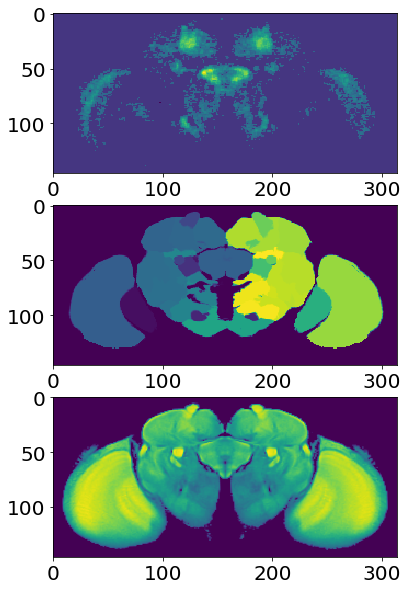

In [10]:
z=50
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.imshow(maps_voxel_res[:,:,z,2].T)
plt.subplot(312)
plt.imshow(atlas[:,:,z].T)
plt.subplot(313)
plt.imshow(out['warpedmovout'][:,:,z].T)

In [11]:
atlas = atlas.numpy()

In [12]:
atlas_int = np.rint(atlas)
atlas_clean = np.copy(atlas_int)
diff_atlas = atlas_int - atlas
thresh = 0.001
atlas_clean[np.where(np.abs(diff_atlas)>thresh)] = 0

(-0.5, 313.5, 145.5, -0.5)

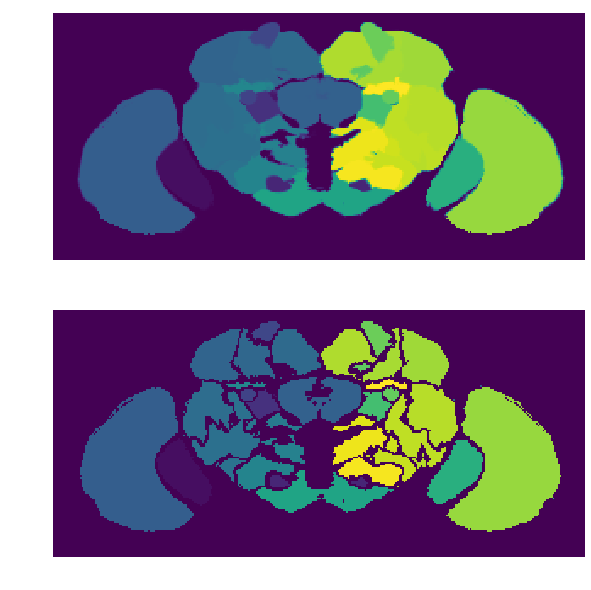

In [13]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(atlas[:,:,50].T)
plt.axis('off')

plt.subplot(212)
plt.imshow(atlas_clean[:,:,50].T)
plt.axis('off')

In [34]:
# grab the MB complex
to_grab = {
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L'
}

In [14]:
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation

In [196]:
####################
### Get roi mask ###
####################

mask = np.zeros(atlas_clean.shape)
mask[np.where(atlas_clean == 26)] = 1

mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
mask_dilated = binary_dilation(mask_eroded, iterations=2)

masked_roi = mask_dilated[...,np.newaxis]*corr_map

# for plotting
left_edge = np.where(np.sum(np.nan_to_num(masked_roi),axis=0)>0)[0][0]
right_edge = np.where(np.sum(np.nan_to_num(masked_roi),axis=0)>0)[0][-1]
top_edge = np.where(np.sum(np.nan_to_num(masked_roi),axis=1)>0)[0][0]
bottom_edge = np.where(np.sum(np.nan_to_num(masked_roi),axis=1)>0)[0][-1]

masked_roi_flat = np.max(masked_roi,axis=2)

In [197]:
#######################
### Get roi contour ###
#######################

# Find slice with maximum roi_mask area - this is what I will use for the contour
maxs = []
for z in range(91):
    
    _, mask_binary = cv2.threshold(mask_dilated[:,:,z].astype('uint8'), 0, 1, cv2.THRESH_BINARY)
    maxs.append(np.sum(mask_binary))

best_slice = np.argmax(maxs)
_, mask_binary = cv2.threshold(mask_dilated[:,:,best_slice].astype('uint8'), 0, 1, cv2.THRESH_BINARY) 
contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#cv2.RETR_TREE

canvas = np.ones(atlas_clean[:,:,0].shape)
out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
out = np.abs(out-1) #flip 0/1
roi_contour = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


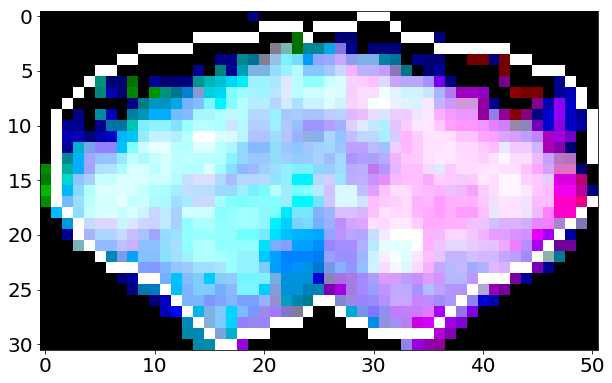

In [198]:
plt.figure(figsize=(10,10))
plt.imshow(np.swapaxes(masked_roi_flat[top_edge:bottom_edge,left_edge:right_edge,:],0,1)*20)
plt.imshow(np.swapaxes(roi_contour[top_edge:bottom_edge,left_edge:right_edge,:],0,1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


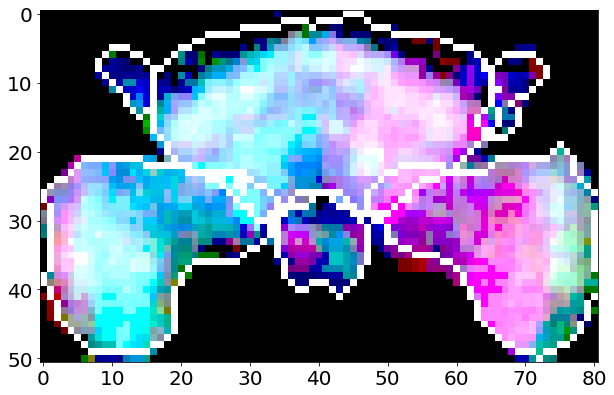

In [247]:
roi_data = []
roi_contours = []

left_edges = []
right_edges = []
bottom_edges = []
top_edges = []

for roi in FB_group.keys():
    ####################
    ### Get roi mask ###
    ####################

    mask = np.zeros(atlas_clean.shape)
    mask[np.where(atlas_clean == roi)] = 1

    mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
    mask_dilated = binary_dilation(mask_eroded, iterations=2)

    masked_roi = mask_dilated[...,np.newaxis]*corr_map

    # for plotting
    left_edges.append(np.where(np.sum(np.nan_to_num(masked_roi),axis=0)>0)[0][0])
    right_edges.append(np.where(np.sum(np.nan_to_num(masked_roi),axis=0)>0)[0][-1])
    top_edges.append(np.where(np.sum(np.nan_to_num(masked_roi),axis=1)>0)[0][0])
    bottom_edges.append(np.where(np.sum(np.nan_to_num(masked_roi),axis=1)>0)[0][-1])
    
    masked_roi_flat = np.max(masked_roi,axis=2)
    roi_data.append(masked_roi_flat)

    #######################
    ### Get roi contour ###
    #######################

    # Find slice with maximum roi_mask area - this is what I will use for the contour
    maxs = []
    for z in range(91):

        _, mask_binary = cv2.threshold(mask_dilated[:,:,z].astype('uint8'), 0, 1, cv2.THRESH_BINARY)
        maxs.append(np.sum(mask_binary))

    best_slice = np.argmax(maxs)
    _, mask_binary = cv2.threshold(mask_dilated[:,:,best_slice].astype('uint8'), 0, 1, cv2.THRESH_BINARY) 
    contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#cv2.RETR_TREE

    canvas = np.ones(atlas_clean[:,:,0].shape)
    out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
    out = np.abs(out-1) #flip 0/1
    roi_contour = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
    roi_contours.append(roi_contour)

# get extreme edges from all rois used
left_edge = np.min(left_edges)
right_edge = np.max(right_edges)
top_edge = np.min(top_edges)
bottom_edge = np.max(bottom_edges)

############
### PLOT ###
############

plt.figure(figsize=(10,10))
full_canvas = np.zeros((314, 146, 3))
for i in range(len(roi_data)):
    full_canvas += roi_data[i]    
plt.imshow(np.swapaxes(full_canvas[top_edge:bottom_edge,left_edge:right_edge,:],0,1)*20)

for i in range(len(roi_contours)):
    plt.imshow(np.swapaxes(roi_contours[i][top_edge:bottom_edge,left_edge:right_edge],0,1))

In [29]:
def plot_grouped_roi_image(rois,plot=True):
    roi_data = []
    roi_contours = []

    left_edges = []
    right_edges = []
    bottom_edges = []
    top_edges = []

    for roi in rois:
        ####################
        ### Get roi mask ###
        ####################

        mask = np.zeros(atlas_clean.shape)
        mask[np.where(atlas_clean == roi)] = 1

        mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
        mask_dilated = binary_dilation(mask_eroded, iterations=2)

        masked_roi = mask_dilated[...,np.newaxis]*corr_map

#         # for plotting
#         left_edges.append(np.where(np.sum(np.nan_to_num(masked_roi),axis=0)>0)[0][0])
#         right_edges.append(np.where(np.sum(np.nan_to_num(masked_roi),axis=0)>0)[0][-1])
#         top_edges.append(np.where(np.sum(np.nan_to_num(masked_roi),axis=1)>0)[0][0])
#         bottom_edges.append(np.where(np.sum(np.nan_to_num(masked_roi),axis=1)>0)[0][-1])

        masked_roi_flat = np.max(masked_roi,axis=2)
        roi_data.append(masked_roi_flat)

        #######################
        ### Get roi contour ###
        #######################
        
        _, mask_binary = cv2.threshold(np.max(mask_dilated,axis=-1).astype('uint8'), 0, 1, cv2.THRESH_BINARY) 
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#cv2.RETR_TREE

        canvas = np.ones(atlas_clean[:,:,0].shape)
        out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
        out = np.abs(out-1) #flip 0/1
        roi_contour = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
        roi_contours.append(roi_contour)

        # for plotting
        left_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][0])
        right_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][-1])
        top_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][0])
        bottom_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][-1])
        
    # get extreme edges from all rois used
    left_edge = np.min(left_edges) - 1
    right_edge = np.max(right_edges) + 1
    top_edge = np.min(top_edges) - 1
    bottom_edge = np.max(bottom_edges) + 1

    ############
    ### PLOT ###
    ############
    
    roi_datas = np.max(np.asarray(roi_data),axis=0)
    data_map = np.swapaxes(roi_datas[top_edge:bottom_edge,left_edge:right_edge,:],0,1)*10#*10000#*20 #here

    if plot:
        plt.figure(figsize=(10,10))
        plt.imshow(data_map)

    contours_to_export = []
    for i in range(len(roi_contours)):
        single_contour = np.swapaxes(roi_contours[i][top_edge:bottom_edge,left_edge:right_edge],0,1)
        contours_to_export.append(single_contour)
        if plot:
            plt.imshow(single_contour)
        
    return data_map, contours_to_export

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


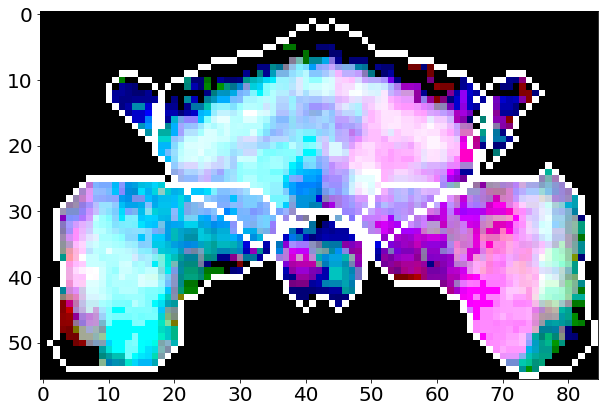

In [434]:
_,_=plot_grouped_roi_image(FB_group.keys())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


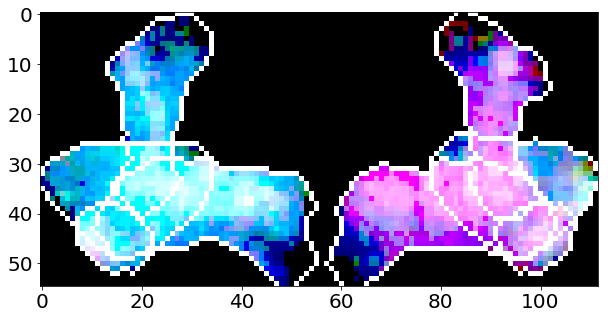

In [305]:
plot_grouped_roi_image(MB_group.keys())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


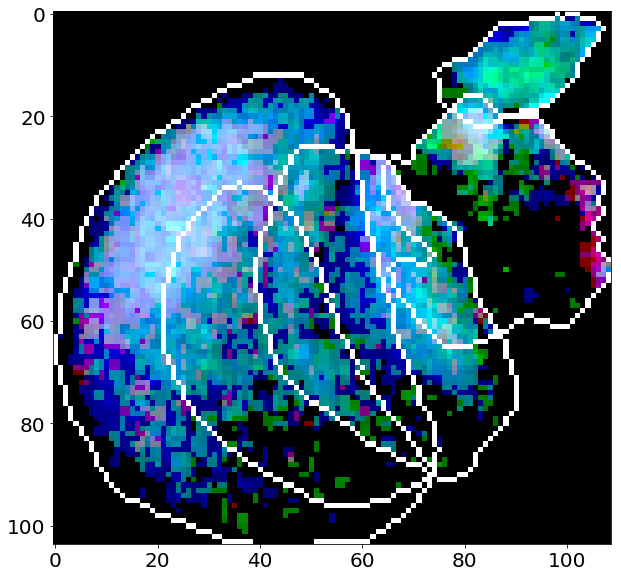

In [432]:
_,_=plot_grouped_roi_image(visual_right_group.keys())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


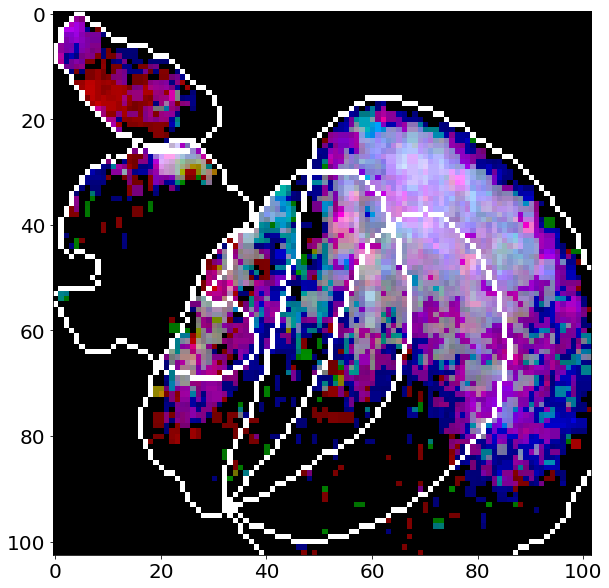

In [308]:
plot_grouped_roi_image(visual_left_group.keys())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


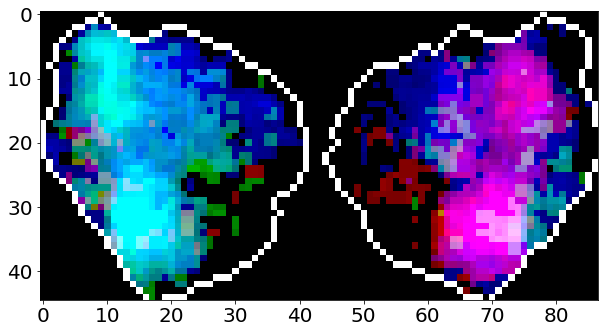

In [277]:
plot_grouped_roi_image(AL_group.keys())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


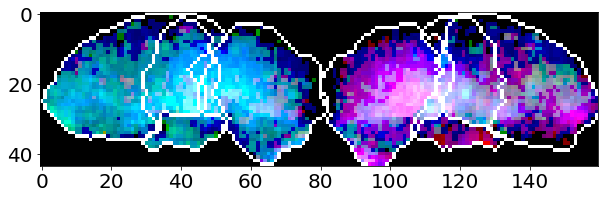

In [281]:
plot_grouped_roi_image(sup_group.keys())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


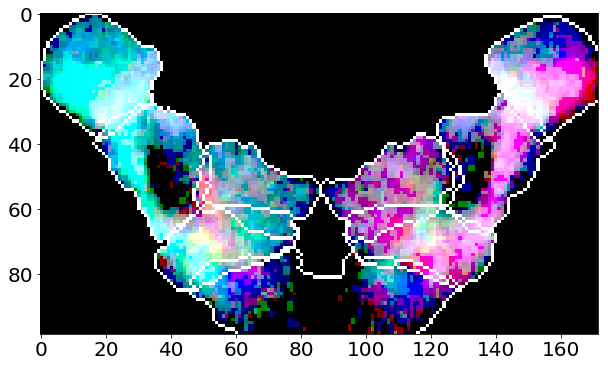

In [289]:
plot_grouped_roi_image(LH_group.keys())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


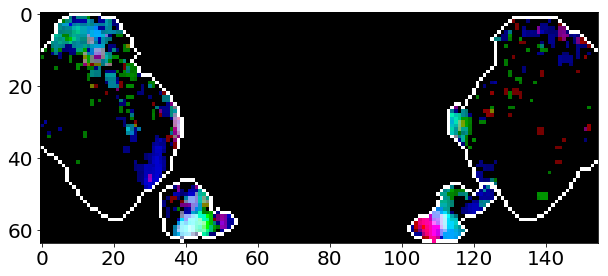

In [295]:
plot_grouped_roi_image(mech_group.keys())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


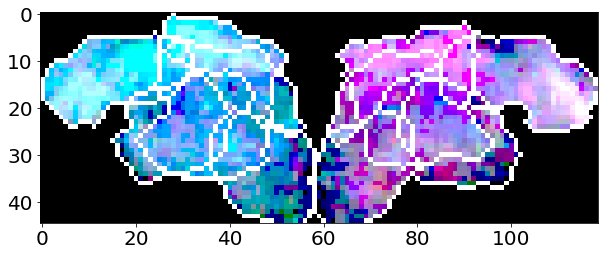

In [299]:
plot_grouped_roi_image(inferior_group.keys())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


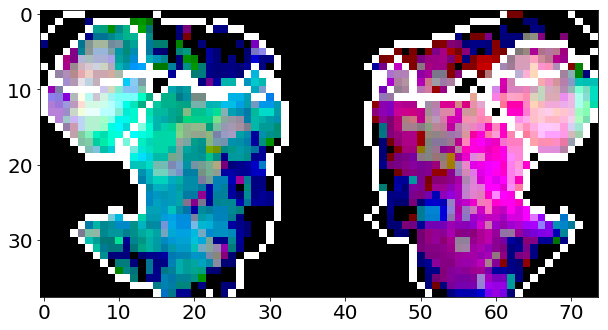

In [302]:
plot_grouped_roi_image(ventromedial_group.keys())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


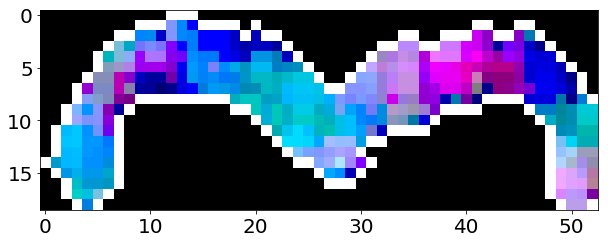

In [310]:
plot_grouped_roi_image(PB.keys())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


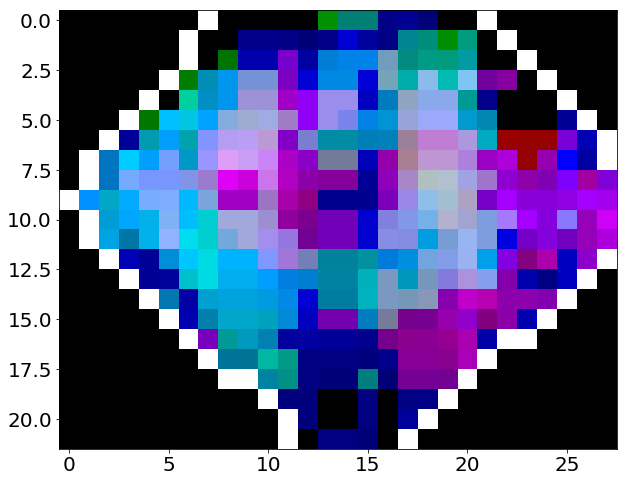

In [311]:
plot_grouped_roi_image(EB.keys())

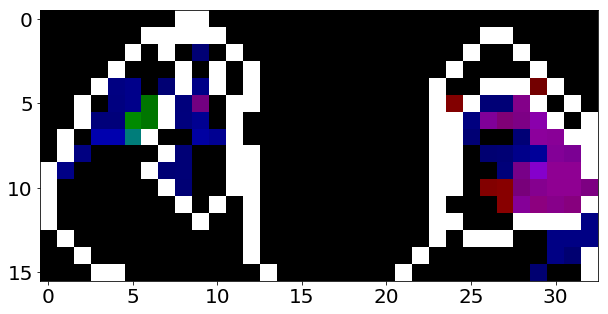

In [313]:
plot_grouped_roi_image(perieso_group.keys())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


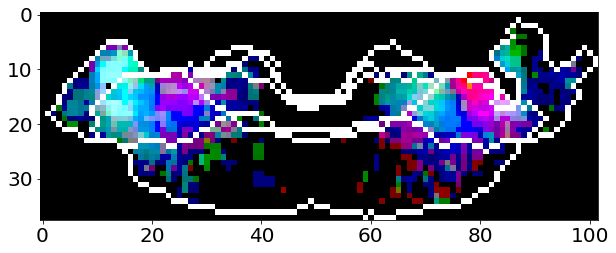

In [545]:
_,_ = plot_grouped_roi_image(mid_group.keys())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


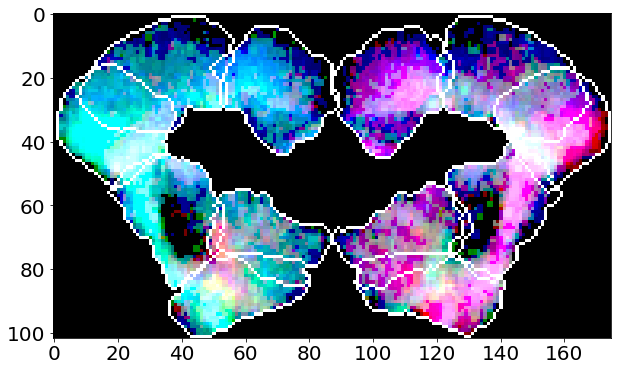

In [499]:
_,_ = plot_grouped_roi_image(big_group.keys())

In [435]:
data_map, contours = plot_grouped_roi_image(FB_group.keys(), plot=False)

In [19]:
def place_on_canvas(input_canvas, to_plot, is_contour=False, is_midline=True, x_shift=0, y_shift=0):
    full_y_mid = int(input_canvas.shape[0]/2)
    full_x_mid = int(input_canvas.shape[1]/2)

    y_mid = int(to_plot.shape[0]/2)
    x_mid = int(to_plot.shape[1]/2)

    height = to_plot.shape[0]
    width = to_plot.shape[1]

    left = full_x_mid-x_mid
    right = left + width

    top = full_y_mid-y_mid
    bottom = top + height

    if is_contour:
        ys = np.where(to_plot[:,:,0]>0)[0] + full_y_mid - y_mid + y_shift
        xs = np.where(to_plot[:,:,0]>0)[1] + full_x_mid - x_mid + x_shift
        input_canvas[ys,xs]=1
    else:
        input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift,:3] = to_plot
        
    return input_canvas

In [20]:
def place_on_canvas_wrapper(canvas, data_map, contours, y_shift, x_shift):
    canvas = place_on_canvas(canvas, to_plot=data_map, y_shift=y_shift, x_shift=x_shift)
    for i in range(len(contours)):
        canvas = place_on_canvas(canvas, to_plot=contours[i], is_contour=True, y_shift=y_shift, x_shift=x_shift)
    return canvas

In [21]:
def wraper_wraper(canvas, roi_ids, y_shift, x_shift):
    data_map, contours = plot_grouped_roi_image(roi_ids, plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    return canvas

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


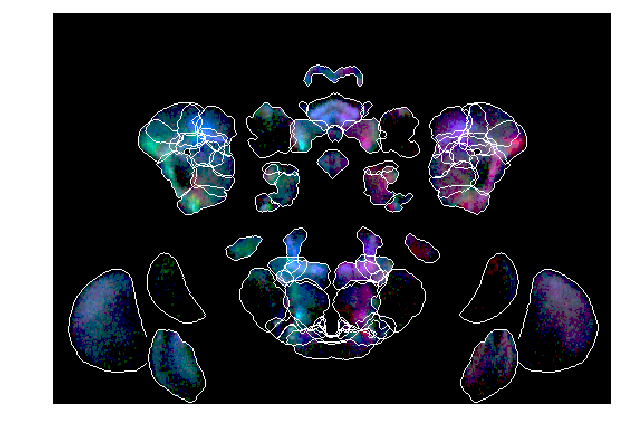

In [30]:
input_canvas = np.zeros((500,500,3))

x_shift=0; y_shift=0
data_map, contours = plot_grouped_roi_image(FB_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=-45
data_map, contours = plot_grouped_roi_image(PB.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=35
data_map, contours = plot_grouped_roi_image({23: 'EB'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##########
### MB ###
##########

# x_shift=60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_left_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
# x_shift=-60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_right_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

#################
### BIG GROUP ###
#################

x_shift=-130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_r_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_l_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##############
### VISUAL ###
##############

x_shift=-200; y_shift=175
data_map, contours = plot_grouped_roi_image({25: 'MED_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=200; y_shift=175
data_map, contours = plot_grouped_roi_image({71: 'MED_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({3: 'LO_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({53: 'LO_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({22: 'LP_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({69: 'LP_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

canvas = wraper_wraper(canvas, ventromedial_r_group.keys(), y_shift=55, x_shift=-50)
canvas = wraper_wraper(canvas, ventromedial_l_group.keys(), y_shift=55, x_shift=50)

canvas = wraper_wraper(canvas, anterior_group.keys(), y_shift=150, x_shift=0)

canvas = wraper_wraper(canvas, {34: 'AOTU_R'}.keys(), y_shift=-50+175-15, x_shift=-80)
canvas = wraper_wraper(canvas, {79: 'AOTU_L'}.keys(), y_shift=-50+175-15, x_shift=80)
    
plt.figure(figsize=(10,10))
#plt.imshow(canvas)
plt.imshow(canvas[150:,:])
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [15]:
##################
### ROI GROUPS ###
##################

FB_group = {
26: 'FB',
4: 'NO',
5: 'BU_R',
54: 'BU_L',
8: 'LAL_R',
56: 'LAL_L',
31: 'PVLP_R',
76: 'PVLP_L'}

ventromedial_r_group = {
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R'}

ventromedial_l_group = {
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L'}

PB = {6: 'PB'}
EB = {23: 'EB'}

anterior_group = {
50: 'PRW',
9: 'SAD',
49: 'GNG',
30: 'AVLP_R',
75: 'AVLP_L',
24: 'AL_R',
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
32: 'IVLP_R',
77: 'IVLP_L',
10: 'CAN_R',
20: 'FLA_R',
57: 'CAN_L',
67: 'FLA_L'}

big_r_group = {
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R'}
    
big_l_group = {
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L'}

In [384]:
contours[0].shape

(51, 81, 4)

In [398]:
test = np.zeros((51, 81, 3))
test[np.where(contours[0][:,:,0]>0)]=1

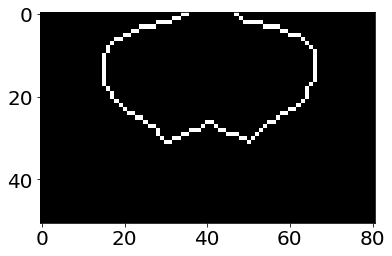

In [399]:
plt.imshow(test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


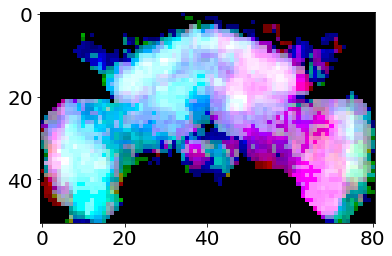

In [352]:
plt.imshow(data_map)

In [ ]:
full_canvas

In [500]:
# perieso_group = {
# 10: 'CAN_R',
# 20: 'FLA_R',
# 57: 'CAN_L',
# 67: 'FLA_L'}

# mech_group = {
# 11: 'AMMC_R',
# 30: 'AVLP_R',
# 58: 'AMMC_L',
# 75: 'AVLP_L'}

# MB_group = {
# 17: 'MB_PED_R',
# 18: 'MB_VL_R',
# 19: 'MB_ML_R',
# 36: 'MB_CA_R',
# 64: 'MB_PED_L',
# 65: 'MB_VL_L',
# 66: 'MB_ML_L',
# 81: 'MB_CA_L'
# }

# MB_left_group = {
# 64: 'MB_PED_L',
# 65: 'MB_VL_L',
# 66: 'MB_ML_L',
# 81: 'MB_CA_L'
# }

# MB_right_group = {
# 17: 'MB_PED_R',
# 18: 'MB_VL_R',
# 19: 'MB_ML_R',
# 36: 'MB_CA_R'
# }

# visual_right_group = {
# 25: 'MED_R',
# 3: 'LO_R',
# 22: 'LP_R',

# 34: 'AOTU_R'
# }

# visual_left_group = {
# 71: 'MED_L',
# 53: 'LO_L',
# 69: 'LP_L',

# 79: 'AOTU_L'
# }

# AL_group = {
# 24: 'AL_R',
# 70: 'AL_L'
# }

# sup_group = {
# 27: 'SLP_R',
# 28: 'SIP_R',
# 72: 'SLP_L',   
# 73: 'SIP_L',
# }

# LH_group = {
# 33: 'PLP_R',
# 7: 'LH_R',
# 78: 'PLP_L',
# 55: 'LH_L',
# 83: 'IPS_L',
# 38: 'IPS_R',
# 49: 'GNG',
# 37: 'SPS_R',
# 82: 'SPS_L'
# }


# inferior_r_group = {
# 16: 'CRE_R',
# 39: 'SCL_R',
# 12: 'ICL_R',
# 15: 'ATL_R',
# 14: 'IB_R'
# }

# inferior_l_group = {
# 63: 'CRE_L',
# 84: 'SCL_L',  
# 59: 'ICL_L',
# 62: 'ATL_L',
# 61: 'IB_L'
# }



In [117]:
mask_dilated.shape

(314, 146, 91)

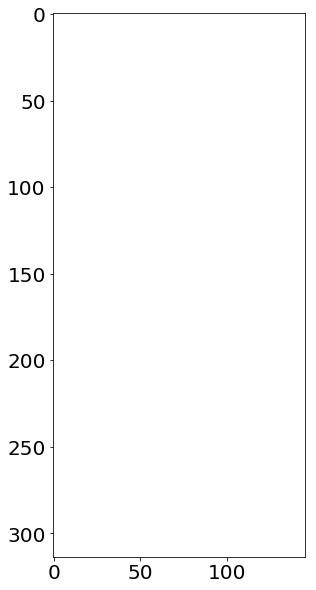

In [150]:
canvas = np.ones(atlas_clean[:,:,0].shape)
out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
out = np.abs(out-1) #flip 0/1
out_ = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
plt.figure(figsize=(10,10))
plt.imshow(out_)

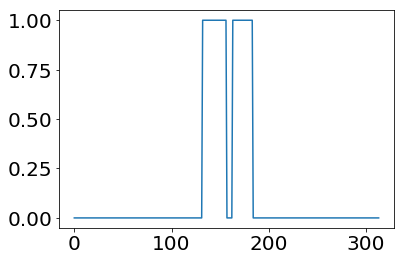

In [134]:
plt.plot(atlas_binary[:,50])

In [135]:
np.sum(atlas_binary)

1120

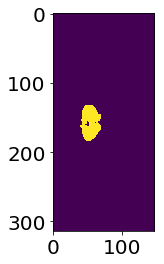

In [136]:
plt.imshow(atlas_binary)

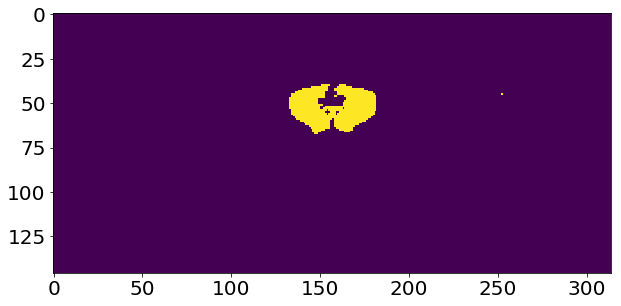

In [92]:
plt.figure(figsize=(10,10))
plt.imshow(mask[:,:,50].T)

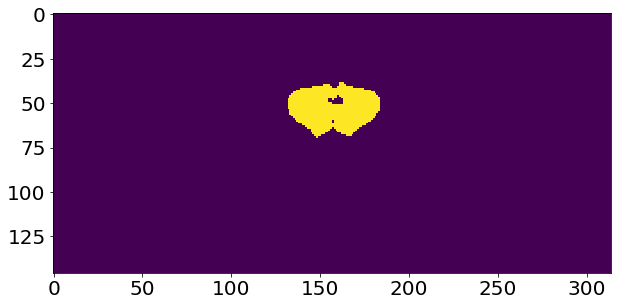

In [95]:
plt.figure(figsize=(10,10))
plt.imshow(mask_dilated[:,:,50].T)

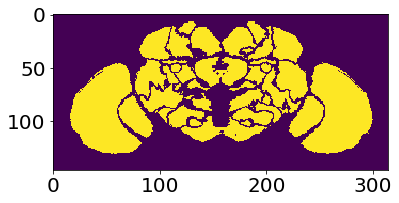

In [188]:
atlas_clean = atlas_clean.astype('uint8')
_, atlas_binary = cv2.threshold(atlas_clean[:,:,50], 0, 1, cv2.THRESH_BINARY)
plt.imshow(atlas_binary.T)

In [182]:
atlas_binary.shape

(314, 146, 91)

In [190]:
atlas_binary_eroded = binary_erosion(atlas_binary, structure=np.ones((2,2)))
atlas_binary_dilated = binary_dilation(atlas_binary_eroded, iterations=2)

In [192]:
_, atlas_binary_dilated = cv2.threshold(atlas_binary_dilated.astype('uint8'), 0, 1, cv2.THRESH_BINARY) 


In [193]:
#cv2.RETR_TREE
#contours, _ = cv2.findContours(atlas_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours, _ = cv2.findContours(atlas_binary_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [194]:
canvas = np.ones(atlas_binary.shape)
out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
out = np.abs(out-1) #flip 0/1

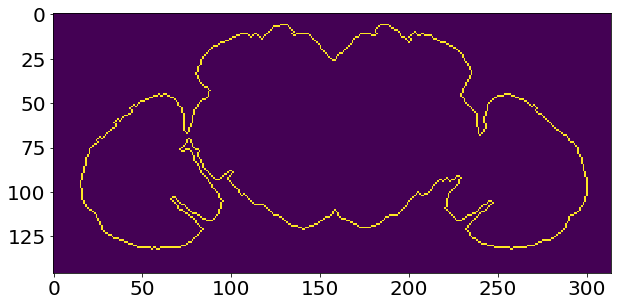

In [195]:
plt.figure(figsize=(10,10))
plt.imshow(out.T)

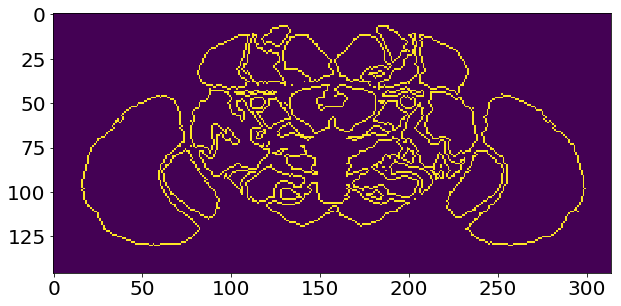

In [178]:
plt.figure(figsize=(10,10))
plt.imshow(out.T)

In [31]:
out_ = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white

In [32]:
out_.shape

(314, 146, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 313.5, 145.5, -0.5)

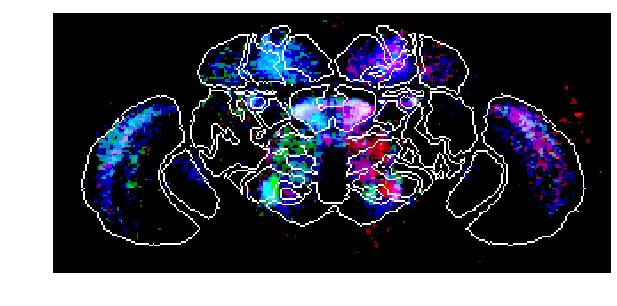

In [33]:
z=50
plt.figure(figsize=(10,10))
plt.imshow(np.swapaxes(maps_voxel_res[:,:,z,:]*20,0,1))
plt.imshow(np.swapaxes(out_,0,1))
plt.axis('off')

In [ ]:
######################
### MID/LEFT/RIGHT ###
######################

####################
rois_mid ={
4: 'NO',
6: 'PB',
9: 'SAD',
23: 'EB',
26: 'FB',
49: 'GNG',
50: 'PRW'
}

####################
rois_right = {
# olfactory #
24: 'AL_R',
7: 'LH_R',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',

# visual #
25: 'MED_R',
3: 'LO_R',
22: 'LP_R',
31: 'PVLP_R',
33: 'PLP_R',
34: 'AOTU_R',

# mechano-sensory #   
11: 'AMMC_R',
32: 'IVLP_R',
30: 'AVLP_R',

# superior #
27: 'SLP_R',
28: 'SIP_R',
29: 'SMP_R',
    
# inferior #
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',

# ventromedial #
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
37: 'SPS_R',
38: 'IPS_R',

# periesophagael #
10: 'CAN_R',
20: 'FLA_R',

    
5: 'BU_R',
8: 'LAL_R'
}

####################
rois_left = {
# olfactory #
70: 'AL_L',
55: 'LH_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
    
# visual #
71: 'MED_L',
53: 'LO_L',
69: 'LP_L',
76: 'PVLP_L',
78: 'PLP_L',
79: 'AOTU_L',

# mechano-sensory #    
58: 'AMMC_L',
77: 'IVLP_L',
75: 'AVLP_L',

# superior #
72: 'SLP_L',   
73: 'SIP_L',
74: 'SMP_L',

# inferior #    
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',

# ventromedial #
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
82: 'SPS_L',
83: 'IPS_L',
    
# periesophagael #
57: 'CAN_L',
67: 'FLA_L',

    
54: 'BU_L',
56: 'LAL_L'
}